In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
from dash import Dash, dcc, html, Input, Output, callback


# 📦 STEP 1: Load and Clean Raw Data

In [2]:
# Load the CSV file
df = pd.read_csv("Year Order Item Data.csv")

# Drop columns that are irrelevant for customer KPI analysis
df.drop(columns=[
    'sap_code', 'delivery_charge',
    'service_charge', 'additional_charge', 'waived_off', 'round_off',
    'customer_address', 'persons', 'order_cancel_reason', 'payment_type',
    'area', 'virtual_brand_name',
    'brand_grouping', 'assign_to'
    ], inplace=True)

# Convert 'date' column to datetime format for further time-based analysis
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')

# Filter out incomplete or failed orders — keep only valid sales
df = df[df['total'] != 0].copy()

df.head()

,restaurant_name,invoice_no,date,order_type,status,customer_phone,customer_name,my_amount,total_tax,discount,container_charge,total,item_name,category_name,item_price,item_quantity,item_total
0,Makers of Milkshakes - Prozone Mall,1,2024-04-01 11:32:59,Pick Up,Success,8.390407e+09,slma saphir,344.23,30.78,0.0,0,375,Strawberry Shake (Milkshake),Classic Shakes,160.64,1,160.64
1,Makers of Milkshakes - Prozone Mall,1,2024-04-01 11:32:59,Pick Up,Success,8.390407e+09,slma saphir,344.23,30.78,0.0,0,375,Chocolate Shake (Milkshake),Instashakes,183.59,1,183.59
2,Makers of Milkshakes - Prozone Mall,2,2024-04-01 12:05:34,Pick Up,Success,9.373995e+09,rahat khan,137.69,12.30,0.0,0,150,Classic Lemonade,Coolers,137.69,1,137.69
3,Makers of Milkshakes - Prozone Mall,3,2024-04-01 12:12:00,Pick Up,Success,8.149381e+09,sania khan,367.18,32.82,0.0,0,400,Waffles,Waffles,183.59,2,367.18
4,Makers of Milkshakes - Prozone Mall,4,2024-04-01 12:13:51,Pick Up,Success,9.156525e+09,pawna mothkuwan,367.18,32.82,0.0,0,400,Banana Shake (Milkshake),Fruit Walker,183.59,1,183.59


# 📞 STEP 2: Focus on Known Customers

In [3]:
# Only analyze orders with known customer phone numbers
df_known = df[df['customer_phone'].notnull()].copy()
df_known = df_known[df_known['order_type'] != "Delivery(Parcel)"].copy()
df_known['customer_phone'] = df_known['customer_phone'].astype(str)

# Extract helpful time fields for grouping and trends
df_known['day'] = df_known['date'].dt.day_name()
df_known['month-year'] = df_known['date'].dt.strftime('%Y-%b')
df_known['month'] = df_known['date'].dt.to_period('M')
df_known['date_only'] = df_known['date'].dt.date
df_known['date_dt'] = pd.to_datetime(df_known['date_only'])

# 📊 STEP 3: Exploratory Visit Stats

In [4]:
# Total visits per day of week
day_wise_visits = (
    df_known.groupby('day')
    .size().reset_index(name='Visits by Day')
    .sort_values(by='Visits by Day', ascending=False)
)

# Total visits per month
monthly_visits = (
    df_known.groupby('month-year')
    .size().reset_index(name='Visits by Month')
    .sort_values(by='Visits by Month', ascending=False)
)


# 💰 STEP 4: Customer-Level KPI Construction

In [5]:
# Step 1: Deduplicate invoice totals to avoid duplicating 'total'
invoice_totals = (
    df_known.groupby(['customer_phone', 'invoice_no'])['total']
    .first()
    .reset_index()
)

# Step 2: Total Spend per customer
total_spend = invoice_totals.groupby('customer_phone')['total'].sum().reset_index(name='Total_Spend_By_Customer')

# Step 3: Average Spend Per Order
avg_spend_order = invoice_totals.groupby('customer_phone')['total'].mean().reset_index(name='Average_Spend_Per_Order')

# Step 4: Total Orders Placed = unique invoices per customer
order_count = invoice_totals.groupby('customer_phone')['invoice_no'].nunique().reset_index(name='Total_Orders_Placed')

# Step 5: Total Items Ordered
item_count = df_known.groupby('customer_phone')['item_quantity'].sum().reset_index(name='Total_Items_Ordered')

# Step 6: Average Spend Per Item
avg_spend_item = total_spend.merge(item_count, on='customer_phone')
avg_spend_item['Average_Spend_Per_Item'] = avg_spend_item['Total_Spend_By_Customer'] / avg_spend_item['Total_Items_Ordered']
avg_spend_item = avg_spend_item[['customer_phone', 'Average_Spend_Per_Item']]

# Step 7: Recency
latest_date = df_known['date'].max()
recency = df_known.groupby('customer_phone')['date'].max().reset_index()
recency['Days_Since_Last_Order'] = (latest_date - recency['date']).dt.days

# Step 8: Tenure
first_order = df_known.groupby('customer_phone')['date_dt'].min().reset_index(name='First_Order_Date')
first_order['Days_Since_First_Order'] = (latest_date - first_order['First_Order_Date']).dt.days



# 🧮 STEP 5: RFM Analysis + Clustering

In [6]:
rfm = (
    recency[['customer_phone', 'Days_Since_Last_Order']]
    .merge(order_count.rename(columns={'Total_Orders_Placed': 'Total_Orders_Placed'}), on='customer_phone')
    .merge(total_spend.rename(columns={'Total_Spend_By_Customer': 'Total_Amount_Spent'}), on='customer_phone')
)

rfm.rename(columns={
    'Days_Since_Last_Order': 'Recency',
    'Total_Orders_Placed': 'Frequency',
    'Total_Amount_Spent': 'Monetary'
}, inplace=True)

rfm['Recency_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['Frequency_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['Monetary_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

rfm['RFM_Total_Score'] = (
    rfm[['Recency_Score', 'Frequency_Score', 'Monetary_Score']]
    .astype(int)
    .sum(axis=1)
)

rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])

# 🟰 STEP 6: K-Means Clustering

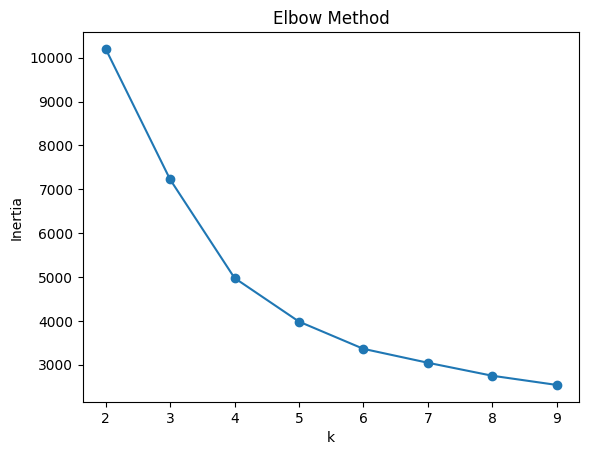

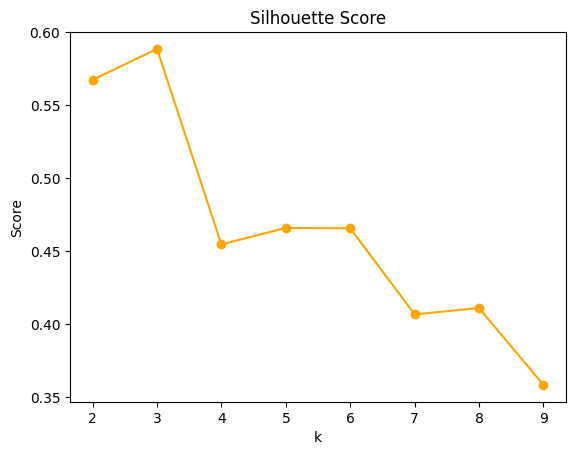

In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

sse = []
sil = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(rfm_scaled)
    sse.append(kmeans.inertia_)
    sil.append(silhouette_score(rfm_scaled, labels))

plt.plot(range(2, 10), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

plt.plot(range(2, 10), sil, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.show()


In [8]:
optimal_k = 3  # or whatever you choose from the above charts
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [ ]:
import plotly.io as pio
pio.renderers.default = 'browser'

rfm_log_clustered = rfm_log.copy()
rfm_log_clustered['Cluster'] = rfm['Cluster'].astype(str)

fig_3d = px.scatter_3d(
    rfm_log_clustered,
    x='Recency',
    y='Frequency',  
    z='Monetary',
    color='Cluster',
    opacity=0.7,
    title='Interactive 3D RFM Cluster Plot (Log-Scaled)',
    labels={
        'Recency': 'Log Recency',
        'Frequency': 'Log Frequency',
        'Monetary': 'Log Monetary',
        'Cluster': 'Customer Segment'
    }
)


# 1. Recency vs Frequency
fig_rf = px.scatter(
    rfm_log_clustered,
    x='Recency',
    y='Frequency',
    color='Cluster',
    opacity=0.7,
    title='Recency vs Frequency (Log-Scaled)',
    labels={
        'Recency': 'Log Recency',
        'Frequency': 'Log Frequency',
        'Cluster': 'Customer Segment'
    }
)

# 2. Recency vs Monetary
fig_rm = px.scatter(
    rfm_log_clustered,
    x='Recency',
    y='Monetary',
    color='Cluster',
    opacity=0.7,
    title='Recency vs Monetary (Log-Scaled)',
    labels={
        'Recency': 'Log Recency',
        'Monetary': 'Log Monetary',
        'Cluster': 'Customer Segment'
    }
)

# 3. Frequency vs Monetary
fig_fm = px.scatter(
    rfm_log_clustered,
    x='Frequency',
    y='Monetary',
    color='Cluster',
    opacity=0.7,
    title='Frequency vs Monetary (Log-Scaled)',
    labels={
        'Frequency': 'Log Frequency',
        'Monetary': 'Log Monetary',
        'Cluster': 'Customer Segment'
    }
)


In [10]:
# Initialize the Dash app
app = Dash(__name__)

# Define the layout
app.layout = html.Div([
    # Header with dropdown
    html.Div([
        html.H1("RFM Customer Analytics Dashboard", 
                style={
                    'textAlign': 'center',
                    'color': '#2c3e50',
                    'fontFamily': 'Arial, sans-serif',
                    'marginBottom': '10px',
                    'fontSize': '2.5rem',
                    'fontWeight': 'bold'
                }),
        html.P("Interactive visualization of customer segmentation analysis",
               style={
                   'textAlign': 'center',
                   'color': '#7f8c8d',
                   'fontSize': '1.1rem',
                   'marginBottom': '20px'
               }),
        
        # Dropdown selector
        html.Div([
            html.Label("Select Visualization:", 
                      style={
                          'fontWeight': 'bold',
                          'marginRight': '10px',
                          'color': '#2c3e50'
                      }),
            dcc.Dropdown(
                id='plot-dropdown',
                options=[
                    {'label': '🎯 3D RFM Cluster Plot', 'value': '3d'},
                    {'label': '📊 Recency vs Frequency', 'value': 'rf'},
                    {'label': '💰 Recency vs Monetary', 'value': 'rm'},
                    {'label': '🔄 Frequency vs Monetary', 'value': 'fm'}
                ],
                value='3d',
                style={
                    'width': '300px',
                    'fontSize': '1rem'
                },
                clearable=False
            )
        ], style={
            'textAlign': 'center',
            'marginBottom': '20px'
        })
    ], style={
        'backgroundColor': '#ecf0f1',
        'padding': '20px',
        'marginBottom': '20px',
        'borderRadius': '10px',
        'boxShadow': '0 2px 10px rgba(0,0,0,0.1)'
    }),
    
    # Graph container
    html.Div([
        dcc.Graph(
            id='main-graph',
            style={'height': '80vh'},  # Full viewport height
            config={
                'displayModeBar': True, 
                'displaylogo': False,
                'toImageButtonOptions': {
                    'format': 'png',
                    'filename': 'rfm_analysis',
                    'height': 800,
                    'width': 1200,
                    'scale': 1
                }
            }
        )
    ], style={
        'backgroundColor': 'white',
        'padding': '20px',
        'borderRadius': '10px',
        'boxShadow': '0 2px 10px rgba(0,0,0,0.1)',
        'minHeight': '85vh'
    })
    
], style={
    'fontFamily': 'Arial, sans-serif',
    'backgroundColor': '#f5f6fa',
    'minHeight': '100vh',
    'padding': '20px'
})

# Callback to update the graph based on dropdown selection
@callback(
    Output('main-graph', 'figure'),
    Input('plot-dropdown', 'value')
)
def update_graph(selected_plot):
    if selected_plot == '3d':
        return fig_3d
    elif selected_plot == 'rf':
        return fig_rf
    elif selected_plot == 'rm':
        return fig_rm
    elif selected_plot == 'fm':
        return fig_fm
    else:
        return fig_3d  # Default fallback


# Run the app
if __name__ == '__main__':
    app.run(jupyter_mode="external")

Dash app running on http://127.0.0.1:8050/


# 🧾 STEP 7: Final Customer KPI Table

In [13]:
# Build the final KPI master sheet
kpi_master = (
    total_spend
    .merge(avg_spend_order, on='customer_phone')
    .merge(order_count, on='customer_phone')
    .merge(avg_spend_item, on='customer_phone')
    .merge(item_count, on='customer_phone')
    .merge(recency[['customer_phone', 'Days_Since_Last_Order']], on='customer_phone')
    .merge(first_order[['customer_phone', 'Days_Since_First_Order']], on='customer_phone')
    .merge(rfm[['customer_phone', 'Cluster']], on='customer_phone'))

# Optional: Attach most frequent name per phone for personalization
name_map = (
    df_known.groupby('customer_phone')['customer_name']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else 'Valued Customer')
    .reset_index()
)
kpi_master = kpi_master.merge(name_map, on='customer_phone', how='left')

In [14]:
# Save the customer-level KPI sheet
kpi_master.to_csv("../results/customer_analysis/Customer_KPIs_KnownPhonesOnly.csv", index=False)